In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Bonds - Amortisation

Attributes
----------
bond
amortisation
amortization
a2b
P&L
"""

toggle_code("Toggle Docstring")

# Bond Amortisation

In this notebook, we demonstrate how when a bond is purchased at a discount or a premium we can calculated the amortisation associated with the position. 

## Table of Contents:
- 1. [Create portfolios](#1.-Create-Portfolios)
- 2. [Creating Bonds](#2.-Create-Bonds)
- 3. [Purchase with Discount/Premium](#3.-Buy-With-Discount/Premium)
- 4. [Valuation](#4.-Valuation)
- 5. [A2B](#5.-A2B)

In [2]:
# Import generic non-LUSID packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import json
import pytz
import time
from IPython.core.display import HTML
from utilities.formatting_tools import cashladder_to_df

# Import key modules from the LUSID package
import lusid as lu
import lusid.models as lm

# Import key functions from Lusid-Python-Tools and other packages
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidtools.cocoon.transaction_type_upload import upsert_transaction_type_alias
from lusidtools.cocoon import load_from_data_frame
from lusidtools.lpt.lpt import to_date
from lusidjam import RefreshingToken

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = lu.utilities.ApiClientFactory(
    token=RefreshingToken(), api_secrets_filename=secrets_path
)

print("LUSID Environment Initialised")
print(
    "LUSID API Version :",
    api_factory.build(lu.api.ApplicationMetadataApi).get_lusid_versions().build_version,
)

LUSID Environment Initialised
LUSID API Version : 0.6.11581.0


In [3]:
# LUSID Variable Definitions
portfolio_api = api_factory.build(lu.api.PortfoliosApi)
transaction_portfolios_api = api_factory.build(lu.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lu.api.PortfoliosApi)
instruments_api = api_factory.build(lu.api.InstrumentsApi)
configuration_recipe_api = api_factory.build(lu.api.ConfigurationRecipeApi)
aggregration_api = api_factory.build(lu.api.AggregationApi)

In [4]:
# Define scopes
scope = "ibor"

# 1. Create Portfolios

We must first create a portfolio to keep our bonds in. We will create two Portfolios with different amortisation methods of:

- Straight Line
- Effective Yield

In [5]:
portfolio_code_straightline = "BondPortfolioForAmortisationUsingStraightLine"

try:
    transaction_portfolios_api.create_portfolio(
        scope=scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code_straightline,
            code=portfolio_code_straightline,
            base_currency="USD",
            created="2010-01-01",
            amortisation_method="StraightLine"
        ),
    )

except lu.ApiException as e:
    print(json.loads(e.body)["title"])

Could not create a portfolio with id 'BondPortfolioForAmortisationUsingStraightLine' because it already exists in scope 'ibor'.


In [6]:
portfolio_code_effectiveyield = "BondPortfolioForAmortisationUsingEffectiveYield"

try:
    transaction_portfolios_api.create_portfolio(
        scope=scope,
        create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
            display_name=portfolio_code_effectiveyield,
            code=portfolio_code_effectiveyield,
            base_currency="USD",
            created="2010-01-01",
            amortisation_method="EffectiveYield"
        ),
    )

except lu.ApiException as e:
    print(json.loads(e.body)["title"])

Could not create a portfolio with id 'BondPortfolioForAmortisationUsingEffectiveYield' because it already exists in scope 'ibor'.


# 2. Create Bonds

We create a function that takes in our bond variables and upserts a bond into LUSID.

In [7]:
def create_bond(
    bond_identifier,
    bond_name,
    coupon_rate,
    start_date,
    maturity_date,
    currency="USD",
    payment_frequency="6M",
    roll_convention="none",
    day_count_convention="ActualActual",
    payment_calendars=[],
    reset_calendars=[],
    settle_days=0,
    reset_days=0,
    dom_ccy="USD",
    principal=100
):

    flow_conventions = lm.FlowConventions(
        currency=currency,
        payment_frequency=payment_frequency,
        roll_convention=roll_convention,
        day_count_convention=day_count_convention,
        payment_calendars=payment_calendars,
        reset_calendars=reset_calendars,
        settle_days=settle_days,
        reset_days=reset_days,
    )

    bond = lm.Bond(
        start_date=start_date,
        maturity_date=maturity_date,
        dom_ccy=dom_ccy,
        principal=principal,
        coupon_rate=coupon_rate,
        flow_conventions=flow_conventions,
        identifiers={},
        instrument_type="Bond",
        calculation_type="Standard",
    )

    # define the instrument to be upserted
    bond_definition = lm.InstrumentDefinition(
        name=bond_name,
        identifiers={"ClientInternal": lm.InstrumentIdValue(bond_identifier)},
        definition=bond,
    )

    # upsert the instrument
    upsert_request = {bond_identifier: bond_definition}
    upsert_response = instruments_api.upsert_instruments(request_body=upsert_request)
    if len(upsert_response.values) == 1:
        return upsert_response
    raise ApiException(f"There were failures in upserting bonds due to {upsert_response.failed}")

# 2.1 Upsert bonds

We can now set the variables of the bond and upsert it into LUSID using the function we built in the cell above. We are creating 3 bonds with different coupon rates but all with the same maturiy date.

In [8]:
bond_1 = create_bond(
    bond_identifier="T_5_31/12/25",
    bond_name="T 5% 31/12/25",
    coupon_rate=0.05,
    start_date=datetime(2019, 1, 1, 0, tzinfo=pytz.utc),
    maturity_date=datetime(2025, 12, 31, 0, tzinfo=pytz.utc)
)

bond_2 = create_bond(
    bond_identifier="T_10_31/12/25",
    bond_name="T 10% 31/12/25",
    coupon_rate=0.10,
    start_date=datetime(2019, 1, 1, 0, tzinfo=pytz.utc),
    maturity_date=datetime(2025, 12, 31, 0, tzinfo=pytz.utc)
)

bond_3 = create_bond(
    bond_identifier="T_2_31/12/25",
    bond_name="T 2% 31/12/25",
    coupon_rate=0.02,
    start_date=datetime(2019, 1, 1, 0, tzinfo=pytz.utc),
    maturity_date=datetime(2025, 12, 31, 0, tzinfo=pytz.utc)
)

# 3. Buy With Discount/Premium

## 3.1 Create Transaction Request

Now that the bonds have been created, we can generate a transaction that adds them to our straight line and effective yield portfolios. We will purchase:

- One at a premium
- One at a discount
- One at par value

In [9]:
transactions = pd.DataFrame({
    "txn_id": ["Premium", "Discount", "Par"] * 2,
    "bond_id": ["T_10_31/12/25", "T_2_31/12/25", "T_5_31/12/25"] * 2,
    "type": "Buy",
    "transaction_date": "2022-01-01",
    "settlement_date": "2022-01-01",
    "quantity": 500000,
    "price": [120, 85, 100] * 2,
    "total_consideration": [500000*120, 500000*85, 500000*100] * 2,
    "currency": "USD",
    "portfolio": [portfolio_code_straightline] * 3 + [portfolio_code_effectiveyield] * 3
})

transactions

,txn_id,bond_id,type,transaction_date,settlement_date,quantity,price,total_consideration,currency,portfolio
0,Premium,T_10_31/12/25,Buy,2022-01-01,2022-01-01,500000,120,60000000,USD,BondPortfolioForAmortisationUsingStraightLine
1,Discount,T_2_31/12/25,Buy,2022-01-01,2022-01-01,500000,85,42500000,USD,BondPortfolioForAmortisationUsingStraightLine
2,Par,T_5_31/12/25,Buy,2022-01-01,2022-01-01,500000,100,50000000,USD,BondPortfolioForAmortisationUsingStraightLine
3,Premium,T_10_31/12/25,Buy,2022-01-01,2022-01-01,500000,120,60000000,USD,BondPortfolioForAmortisationUsingEffectiveYield
4,Discount,T_2_31/12/25,Buy,2022-01-01,2022-01-01,500000,85,42500000,USD,BondPortfolioForAmortisationUsingEffectiveYield
5,Par,T_5_31/12/25,Buy,2022-01-01,2022-01-01,500000,100,50000000,USD,BondPortfolioForAmortisationUsingEffectiveYield


In [10]:
response = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required={
        "code": "portfolio",
        "transaction_id": "txn_id",
        "type": "type",
        "transaction_date": "transaction_date",
        "settlement_date": "settlement_date",
        "units": "quantity",
        "total_consideration.amount": "total_consideration",
        "total_consideration.currency": "currency"
    },
    mapping_optional={
        "transaction_price.price": "price",
        "transaction_price.type": "$Price",
        "transaction_currency": "currency"
    },
    file_type="transactions",
    identifier_mapping={
        "ClientInternal": "bond_id"
    }
)

if len(response["transactions"]["errors"]) > 0:
    raise ApiException("Transactions failed to load")
    
print("Portfolios with Transactions Loaded Successfully:", len(response["transactions"]["success"]))

Portfolios with Transactions Loaded Successfully: 2


# 4. Valuation

Now that the bonds have been booked into our portfolios, we can produce the amortisation over time. The recipe below describes how we will go about valuing the credit instruments in our portfolio (in this case just our bond). We are going to make a simplifying assumption that the value of money over time is constant in order to value or bonds using their future cash flows without any discounting.

## 4.1 Create valuation recipe

In [11]:
# Create a recipe to perform a valuation
configuration_recipe = lm.ConfigurationRecipe(
    scope=scope,
    code="bondValuationUsingConstantTimeValueOfMoney",
    market=lm.MarketContext(
        options=lm.MarketOptions(
            default_supplier="Lusid",
            default_instrument_code_type="ClientInternal",
            default_scope=scope,
        ),
    ),
    pricing=lm.PricingContext(
        model_rules=[
            lm.VendorModelRule(
                supplier="Lusid",
                model_name="ConstantTimeValueOfMoney",
                instrument_type="Bond",
                parameters="{}",
            )
        ]
    )
)

upsert_configuration_recipe_response = (
    configuration_recipe_api.upsert_configuration_recipe(
        upsert_recipe_request=lm.UpsertRecipeRequest(
            configuration_recipe=configuration_recipe
        )
    )
)

In [12]:
upsert_configuration_recipe_response

{'href': None,
 'links': [{'description': 'A link to the LUSID Insights website showing all '
                           'logs related to this request',
            'href': 'http://demo.lusid.com/app/insights/logs/0HMRV6CMJBMSK:00000083',
            'method': 'GET',
            'relation': 'RequestLogs'}],
 'value': datetime.datetime(2023, 7, 10, 4, 20, 33, 434747, tzinfo=tzlocal())}

## 4.2 Create daily valuation function

Now that we have produced a recipe, we can now create a function that outputs a dataframe with the valuation of our portfolio with the amortisation values.

In [13]:
def get_amortisation(portfolio_code):
    
    aggregationMetrics={
        "Instrument/default/Name":
        {
            "operation": "Value",
            "display": "InstrumentName",
            "groupby": True
        },
        "Instrument/default/ClientInternal":
        {
            "operation": "Value",
            "display": "ClientInternalId",
            "groupby": False
        },
        "Holding/TaxLotId":
        {
            "operation": "Value",
            "display": "TaxLotId",
            "groupby": True
        },
        "Holding/Amortisation":
        {
            "operation": "Value",
            "display": "TotalAmortisation",
            "groupby": False
        },
        "Analytic/default/ValuationDate":
        {
            "operation": "Value",
            "display": "Date",
            "groupby": True
        },
    }
    
    valuation_request = lm.ValuationRequest(
        recipe_id=lm.ResourceId(scope=scope, code="bondValuationUsingConstantTimeValueOfMoney"),
        metrics=[
            lm.AggregateSpec(metric, d['operation'])
            for metric,d in aggregationMetrics.items()
        ],
        group_by=[metric for metric,d in aggregationMetrics.items() if d['groupby']],
        portfolio_entity_ids=[lm.PortfolioEntityId(scope=scope, 
                                                             code=portfolio_code,
                                                            portfolio_entity_type = "SinglePortfolio" )],
        valuation_schedule=lm.ValuationSchedule(
            effective_at=datetime(2022, 1, 1, 0, tzinfo=pytz.utc).isoformat(), 
            valuation_date_times=[(datetime(2022, 1, 1, 0, tzinfo=pytz.utc)+timedelta(days=i)).isoformat() 
                                  for i in range((datetime(2025, 12, 31, 0, tzinfo=pytz.utc)-datetime(2022, 1, 1, 0, tzinfo=pytz.utc)).days)]),
    )

    val_data = aggregration_api.get_valuation(valuation_request=valuation_request).data

    vals_df = pd.DataFrame(val_data)

    vals_df.rename(
        columns={metric: d['display']
                 for metric,d in aggregationMetrics.items()},
        inplace=True,
    )
    
    vals_df['Date'] = vals_df['Date'].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d').date())

    return vals_df

In [14]:
straight_line = get_amortisation(portfolio_code_straightline)
effective_yield = get_amortisation(portfolio_code_effectiveyield)

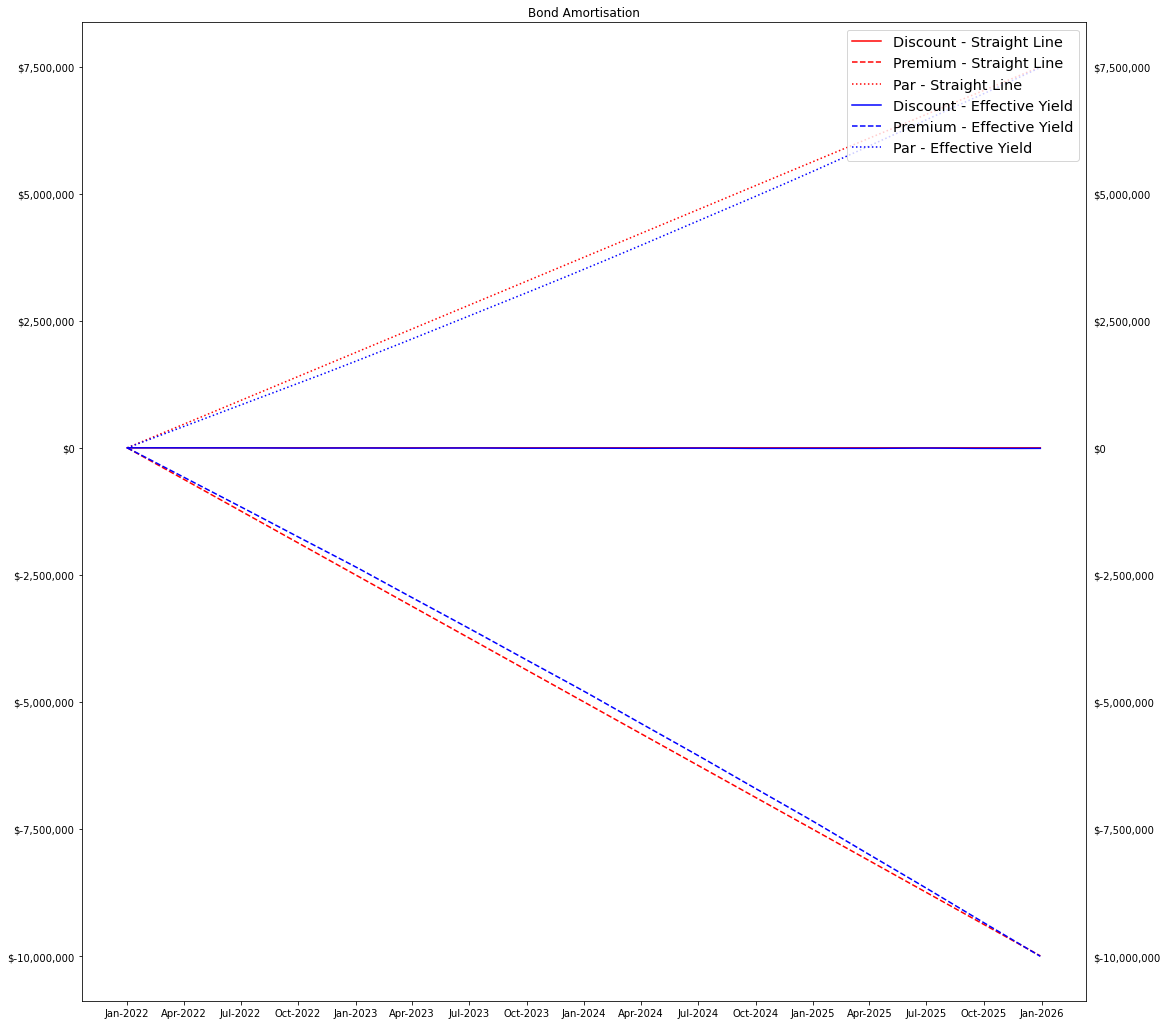

In [15]:
fig, ax = plt.subplots(figsize=(18,18))
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.yaxis.set_tick_params(which='major',
                         labelleft=True, labelright=True)
ax.set_title("Bond Amortisation")

# red dashes, blue squares and green triangles
plt.plot_date(
    straight_line.loc[straight_line["ClientInternalId"] == "T_5_31/12/25", "Date"], 
    straight_line.loc[straight_line["ClientInternalId"] == "T_5_31/12/25", "TotalAmortisation"], 
    'r-', 
    label="Discount - Straight Line"
)

plt.plot_date(
    straight_line.loc[straight_line["ClientInternalId"] == "T_10_31/12/25", "Date"], 
    straight_line.loc[straight_line["ClientInternalId"] == "T_10_31/12/25", "TotalAmortisation"], 
    'r--',
    label="Premium - Straight Line"
)

plt.plot_date(
    straight_line.loc[straight_line["ClientInternalId"] == "T_2_31/12/25", "Date"],  
    straight_line.loc[straight_line["ClientInternalId"] == "T_2_31/12/25", "TotalAmortisation"], 
    'r:',
    label="Par - Straight Line"
)

plt.plot_date(
    effective_yield.loc[straight_line["ClientInternalId"] == "T_5_31/12/25", "Date"], 
    effective_yield.loc[straight_line["ClientInternalId"] == "T_5_31/12/25", "TotalAmortisation"], 
    'b-',
    label="Discount - Effective Yield"
)

plt.plot_date(
    effective_yield.loc[straight_line["ClientInternalId"] == "T_10_31/12/25", "Date"], 
    effective_yield.loc[straight_line["ClientInternalId"] == "T_10_31/12/25", "TotalAmortisation"], 
    'b--',
    label="Premium - Effective Yield"
)

plt.plot_date(
    effective_yield.loc[straight_line["ClientInternalId"] == "T_2_31/12/25", "Date"],  
    effective_yield.loc[straight_line["ClientInternalId"] == "T_2_31/12/25", "TotalAmortisation"], 
    'b:',
    label="Par - Effective Yield"
)
import matplotlib.dates as mdate
locator = mdate.MonthLocator((1,4,7,10))
fmt = mdate.DateFormatter('%b-%Y')

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)

ax.legend(loc="upper right", fontsize="x-large")
plt.show()

# 5. A2B

In addition to amortisation we may also be interested in seeing how our bond accrues interest and gains value over time. We can do this via running an [A2B report](https://support.lusid.com/knowledgebase/article/KA-01945/en-us). Similar to a profit and loss explain, this report shows us how our position has moved between two dates. The start date (A) and the end date (B). In this case we will set the start date before we purchased our bonds and the end date just a couple of months before maturity.

In [16]:
a2b = transaction_portfolios_api.get_a2_b_movements(
    scope=scope,
    code=portfolio_code_straightline,
    from_effective_at="2010-01-30",
    to_effective_at="2025-10-29",
    recipe_id_scope=scope,
    recipe_id_code="bondValuationUsingConstantTimeValueOfMoney"
)

In [17]:
instrument_to_trans_lookup = {
    movement.instrument_uid: movement.transaction_id for movement in a2b.values 
    if ((movement.instrument_uid != 'CCY_USD') and (movement.transaction_id is not None))
}

data = {}

for movement in a2b.values:
    if movement.instrument_uid == 'CCY_USD':
        continue

    if movement.transaction_id is None:
        data[f"{instrument_to_trans_lookup[movement.instrument_uid]}"] = {
            component_name: component_value
            for component_name, component_value  in movement.end.holding_currency.components.items()
        }
        continue
    
x = []

values = {
    "MarketGain": [],
    "AccruedInterest": [],
    "Amortisation": []
}

for key, value in data.items():
    x.append(key)
    for component_name in values.keys():
        values[component_name].append(value.get(component_name, 0))

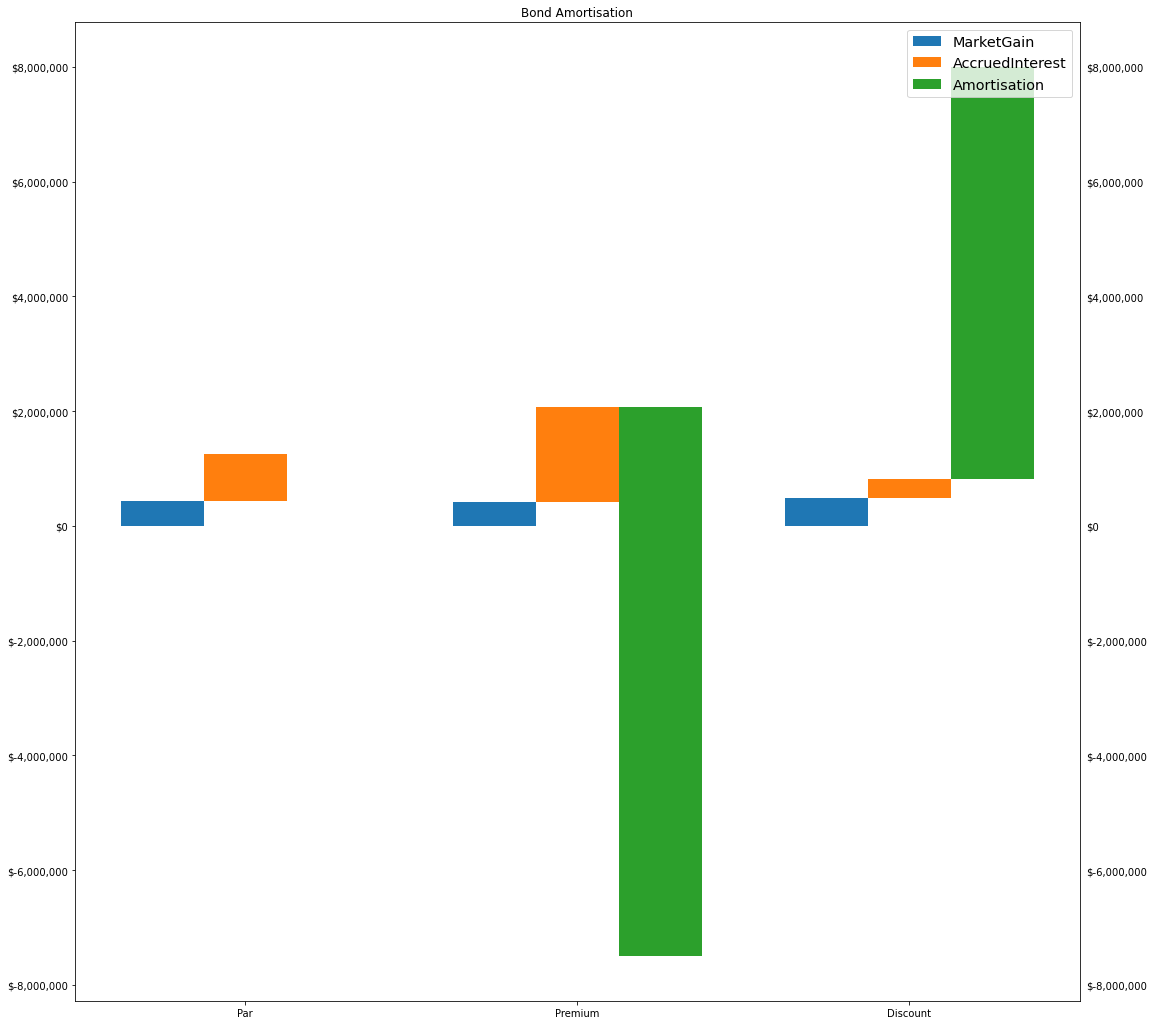

In [18]:
width = 0.2

x_loc = np.arange(len(x))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(18,18))
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.yaxis.set_tick_params(which='major',
                         labelleft=True, labelright=True)

bottom = np.zeros(3)

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x_loc + offset, measurement, width, label=attribute, bottom=bottom)
    multiplier += 1
    bottom += measurement

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("Bond Amortisation")
ax.legend(loc="upper right", fontsize="x-large")
ax.set_xticks(x_loc + width, x)

plt.show()

## We can use the links below to view the A2B report in the LUSID website

In [19]:
api_url = api_factory.api_client.configuration._base_path.replace("api","")

In [20]:
api_url + 'app/dashboard/a2b?dateFrom=2010-01-30T23:00:00.000Z&dateTo=2025-12-29T23:59:59.999Z&scope=ibor&code=BondPortfolioForAmortisationUsingEffectiveYield&entityType=Portfolio&recipeScope=ibor&recipeCode=bondValuationUsingConstantTimeValueOfMoney&effectiveDate=2025-12-29T23:59:59.999Z'

'https://demo.lusid.com/app/dashboard/a2b?dateFrom=2010-01-30T23:00:00.000Z&dateTo=2025-12-29T23:59:59.999Z&scope=ibor&code=BondPortfolioForAmortisationUsingEffectiveYield&entityType=Portfolio&recipeScope=ibor&recipeCode=bondValuationUsingConstantTimeValueOfMoney&effectiveDate=2025-12-29T23:59:59.999Z'

In [21]:
api_url + 'app/dashboard/a2b?dateFrom=2010-01-30T23:00:00.000Z&dateTo=2025-12-29T23:59:59.999Z&scope=ibor&code=BondPortfolioForAmortisationUsingStraightLine&entityType=Portfolio&recipeScope=ibor&recipeCode=bondValuationUsingConstantTimeValueOfMoney&effectiveDate=2025-12-29T23:59:59.999Z'

'https://demo.lusid.com/app/dashboard/a2b?dateFrom=2010-01-30T23:00:00.000Z&dateTo=2025-12-29T23:59:59.999Z&scope=ibor&code=BondPortfolioForAmortisationUsingStraightLine&entityType=Portfolio&recipeScope=ibor&recipeCode=bondValuationUsingConstantTimeValueOfMoney&effectiveDate=2025-12-29T23:59:59.999Z'

### Clean Up

In [22]:
portfolios_api.delete_portfolio(
    scope=scope,
    code=portfolio_code_effectiveyield,
)

portfolios_api.delete_portfolio(
    scope=scope,
    code=portfolio_code_straightline,
)

{'as_at': datetime.datetime(2023, 7, 10, 4, 21, 12, 743263, tzinfo=tzlocal()),
 'effective_from': datetime.datetime(2010, 1, 1, 0, 0, tzinfo=tzlocal()),
 'href': None,
 'links': [{'description': 'A link to the LUSID Insights website showing all '
                           'logs related to this request',
            'href': 'http://demo.lusid.com/app/insights/logs/0HMRV6D0R4777:000000A1',
            'method': 'GET',
            'relation': 'RequestLogs'}]}